In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import importlib
import os
from glob import glob
from tqdm.auto import tqdm
import numpy as np

import datetime

from  utility_programs.read_routines import SAMI

import cartopy.crs as ccrs

In [2]:
sami_data_path = '/glade/u/home/abukowski/scratch/simstorm-20110521/GITM-simstorm-run1/sami-gitm-coupled/'

In [3]:
nx, ny = SAMI.get_postprocessed_grid(sami_data_path)

In [4]:
nz, nf, nlt, nt = SAMI.get_grid_elems_from_parammod(sami_data_path)

In [5]:
nt +=1

In [6]:
nx, ny, nlt, nt

(100, 100, 80, 625)

In [7]:
grid = {'alt':'galt0.dat',
        'lat':'glat0.dat',
        'lon':'glon0.dat'}

attrs = {
    'alt':{'long_name':'Altitude','units':'km',},
    'lon':{'long_name':'longitude','units':'degrees_east'},
    'lat':{'long_name':'latitude','units':'degrees_east'},
    'dene':{'long_name':'electron density','units':'cm^-3'},
    'tec':{'long_name':'Total Electron Content','units':'TECUnits'},
    }

data = {'dene':['dene0G.dat',[nt,nlt,nx,ny]],}

alt_int = {'tec':['tecuG.dat',[nt,nlt,nx]],
        'nmf2':['nmf2uG.dat',[nt,nlt,nx]],
        'hmf2':['hmf2uG.dat',[nt,nlt,nx]]}


In [8]:
data_dict = {}

In [9]:
times = SAMI.make_times(
        nt, sami_data_path,
        dtime_sim_start=datetime.datetime(2011, 5, 20))

data_dict['time'] = times

In [10]:
coords = {}

for g in grid:
    file = open(os.path.join(sami_data_path, grid[g]), 'rb')
    raw = np.fromfile(file, dtype='float32')[1:-1].copy()
    file.close()

    coords[g] = raw


In [11]:
ds = xr.Dataset(coords = {
    'time':(['time'],times,),
    'alt':(['alt'],coords['alt'],attrs['alt']),
    'lat':(['lat'],coords['lat'],attrs['lat']),
    'lon':(['lon'],coords['lon'],attrs['lon'])})

In [12]:
ds

<xarray.Dataset>
Dimensions:  (time: 625, alt: 100, lat: 100, lon: 80)
Coordinates:
  * time     (time) datetime64[ns] 2011-05-20 ... 2011-05-22T04:00:00
  * alt      (alt) float32 90.0 97.11 104.3 ... 2.059e+03 2.129e+03 2.2e+03
  * lat      (lat) float32 -89.77 -87.96 -86.14 -84.33 ... 86.21 88.02 89.83
  * lon      (lon) float32 290.1 294.7 299.3 303.7 ... 271.7 276.3 280.8 285.4
Data variables:
    *empty*

In [13]:
for f in data:
    file = open(os.path.join(sami_data_path, data[f][0]), 'rb')
    raw = np.fromfile(file, dtype='float32')[1:-1].copy()
    file.close()

    ds[f] = (['time','lon','lat','alt'],raw.reshape(data[f][1]), attrs[f] if f in attrs.keys() else '')

for f in alt_int:
    file = open(os.path.join(sami_data_path, alt_int[f][0]), 'rb')
    raw = np.fromfile(file, dtype='float32')[1:-1].copy()
    file.close()

    ds[f] = (['time','lon','lat'],raw.reshape(alt_int[f][1]), attrs[f] if f in attrs.keys() else '')

In [14]:
ds

<xarray.Dataset>
Dimensions:  (time: 625, alt: 100, lat: 100, lon: 80)
Coordinates:
  * time     (time) datetime64[ns] 2011-05-20 ... 2011-05-22T04:00:00
  * alt      (alt) float32 90.0 97.11 104.3 ... 2.059e+03 2.129e+03 2.2e+03
  * lat      (lat) float32 -89.77 -87.96 -86.14 -84.33 ... 86.21 88.02 89.83
  * lon      (lon) float32 290.1 294.7 299.3 303.7 ... 271.7 276.3 280.8 285.4
Data variables:
    dene     (time, lon, lat, alt) float32 1.0 1.0 1.0 ... 3.864e+03 1.29e+03
    tec      (time, lon, lat) float32 0.0001969 0.0001969 ... 10.89 3.645
    nmf2     (time, lon, lat) float32 1.0 1.0 1.0 ... 2.021e+05 6.766e+04
    hmf2     (time, lon, lat) float32 204.9 204.9 204.9 ... 352.2 352.2 352.2

In [15]:
ds = ds.sortby('lat').sortby('lon')

In [16]:
ds

<xarray.Dataset>
Dimensions:  (time: 625, alt: 100, lat: 100, lon: 80)
Coordinates:
  * time     (time) datetime64[ns] 2011-05-20 ... 2011-05-22T04:00:00
  * alt      (alt) float32 90.0 97.11 104.3 ... 2.059e+03 2.129e+03 2.2e+03
  * lat      (lat) float32 -89.77 -87.96 -86.14 -84.33 ... 86.21 88.02 89.83
  * lon      (lon) float32 4.305 8.891 13.52 18.18 ... 346.5 350.9 355.3 359.8
Data variables:
    dene     (time, lon, lat, alt) float32 1.0 1.0 1.0 ... 3.589e+03 1.218e+03
    tec      (time, lon, lat) float32 0.0001969 0.0001969 ... 9.55 3.257
    nmf2     (time, lon, lat) float32 1.0 1.0 1.0 ... 1.612e+05 5.532e+04
    hmf2     (time, lon, lat) float32 204.9 204.9 204.9 ... 405.4 405.4 405.4

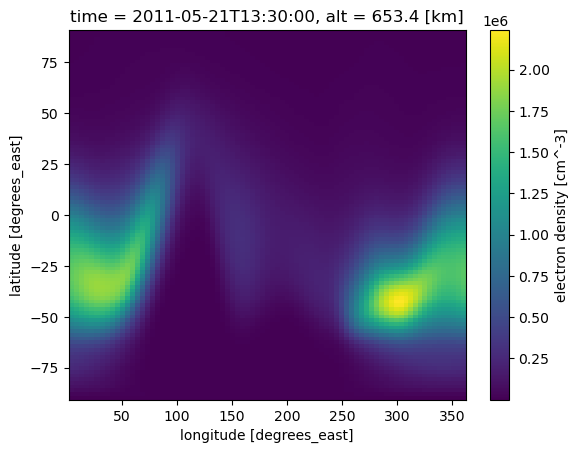

In [17]:
ds.isel(time=450).sel(alt=650,method='nearest').dene.plot(x='lon',y='lat')

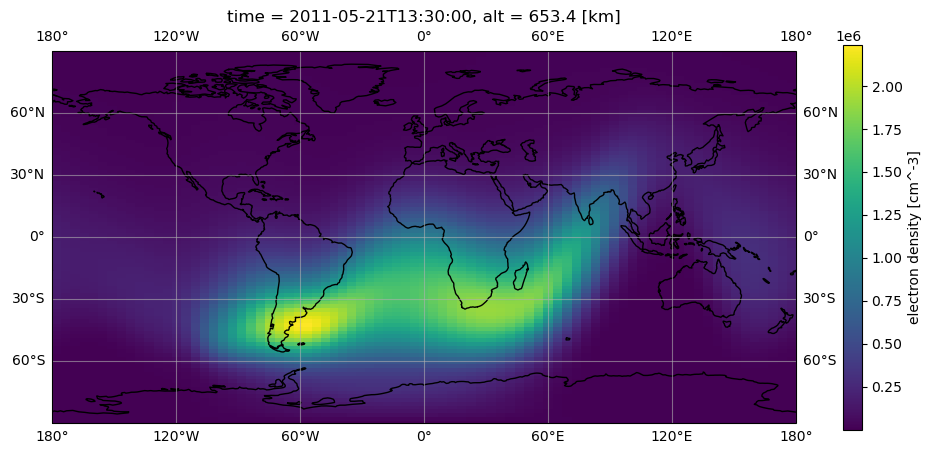

In [18]:
plt.figure(figsize = (12,5))
ax = plt.subplot(projection=ccrs.PlateCarree(), )

ds.isel(time=450).sel(alt=650,method='nearest').dene.T.plot(ax = ax)

ax.coastlines()
ax.gridlines(draw_labels = True, alpha = 0.6)


In [19]:
mag, times = SAMI.read_sami_dene_tec_MAG_GRID(sami_data_path)

In [20]:
a = np.where(mag['grid']['alt'] == 653.3933)

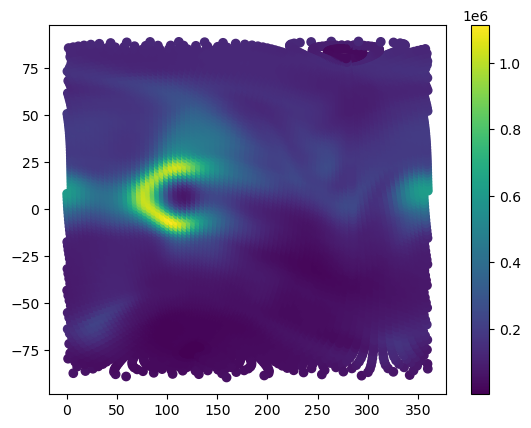

In [21]:
plt.scatter(mag['grid']['glon'][:,a,:],mag['grid']['glat'][:,a,:], c = mag['data']['edens'][450,:,a,:])
plt.colorbar()

In [22]:
SAMI = importlib.reload(SAMI)

In [23]:
ds2 = SAMI.read_raw_to_xarray(sami_data_path,datetime.datetime(2011,5,20), cols = 'edens',
                              dtime_storm_start=datetime.datetime(2011,5,21,12),
                             hrs_before_storm_start=1, hrs_after_storm_start=3, progress_bar=True)

Reading SAMI binaries:   0%|          | 0/25 [00:00<?, ?it/s]

In [25]:
ds2

<xarray.Dataset>
Dimensions:  (time: 624, nlt: 80, nf: 72, nz: 256)
Coordinates:
  * time     (time) datetime64[ns] 2011-05-20 ... 2011-05-22T03:55:00
    mlat     (nlt, nf, nz) float32 -1.99 -1.99 -1.99 -1.98 ... 87.68 87.68 87.68
    mlon     (nlt, nf, nz) float32 2.25 2.25 2.25 2.25 ... 357.8 357.8 357.8
    malt     (nlt, nf, nz) float32 6.451e+03 6.451e+03 ... 6.458e+03 6.456e+03
    glat     (nlt, nf, nz) float32 -13.74 -13.74 -13.74 ... 80.04 80.04 80.04
    glon     (nlt, nf, nz) float32 290.3 290.3 290.3 290.3 ... 277.6 277.6 277.6
    alt      (nlt, nf, nz) float32 80.02 80.03 80.05 80.06 ... 89.94 87.09 84.4
Dimensions without coordinates: nlt, nf, nz
Data variables:
    edens    (time, nlt, nf, nz) float64 56.15 56.15 46.0 43.87 ... 0.0 0.0 0.0
Attributes:
    dtime_event_start:  2011-05-21 12:00:00

In [26]:
ds2.load()

<xarray.Dataset>
Dimensions:  (time: 624, nlt: 80, nf: 72, nz: 256)
Coordinates:
  * time     (time) datetime64[ns] 2011-05-20 ... 2011-05-22T03:55:00
    mlat     (nlt, nf, nz) float32 -1.99 -1.99 -1.99 -1.98 ... 87.68 87.68 87.68
    mlon     (nlt, nf, nz) float32 2.25 2.25 2.25 2.25 ... 357.8 357.8 357.8
    malt     (nlt, nf, nz) float32 6.451e+03 6.451e+03 ... 6.458e+03 6.456e+03
    glat     (nlt, nf, nz) float32 -13.74 -13.74 -13.74 ... 80.04 80.04 80.04
    glon     (nlt, nf, nz) float32 290.3 290.3 290.3 290.3 ... 277.6 277.6 277.6
    alt      (nlt, nf, nz) float32 80.02 80.03 80.05 80.06 ... 89.94 87.09 84.4
Dimensions without coordinates: nlt, nf, nz
Data variables:
    edens    (time, nlt, nf, nz) float64 56.15 56.15 46.0 43.87 ... 0.0 0.0 0.0
Attributes:
    dtime_event_start:  2011-05-21 12:00:00